In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [50]:
import datetime as dt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
train = pd.read_csv("train_data_iitm.csv")
train_mapping = pd.read_csv("taxi_zone_mapping.csv")
test = pd.read_csv("test_data_iitm.csv")

# Merging train and with taxi_zone_mapping

In [52]:
def train_map(train):
    
    train_mapping_1 = train_mapping.copy()
    train_mapping_2 = train_mapping.copy()
    
    train_mapping_PU = train_mapping_1
    train_mapping_PU = train_mapping_PU.drop(columns="Zone")
    train_mapping_PU["PULocationID"] = train_mapping_PU["LocationID"]
    train_mapping_PU["PUBorough"] = train_mapping_PU["Borough"]
    train_mapping_PU["PUservice_zone"] = train_mapping_PU["service_zone"]
    train_mapping_PU = train_mapping_PU.drop(columns="Borough")
    train_mapping_PU = train_mapping_PU.drop(columns="service_zone")
    train_mapping_PU = train_mapping_PU.drop(columns="LocationID")

    train_mapping_DO = train_mapping_1
    train_mapping_DO = train_mapping_DO.drop(columns="Zone")
    train_mapping_DO["DOLocationID"] = train_mapping_DO["LocationID"]
    train_mapping_DO["DOBorough"] = train_mapping_DO["Borough"]
    train_mapping_DO["DOservice_zone"] = train_mapping_DO["service_zone"]
    train_mapping_DO = train_mapping_DO.drop(columns="Borough")
    train_mapping_DO = train_mapping_DO.drop(columns="service_zone")
    train_mapping_DO = train_mapping_DO.drop(columns="LocationID")

    train = pd.merge(train, train_mapping_PU, on='PULocationID')
    train = pd.merge(train, train_mapping_DO, on='DOLocationID')
    
    return train

In [53]:
train = pd.read_csv("train_data_iitm.csv")
train = train.dropna()
train = train[train["fare_amount"]>0]

test = pd.read_csv("test_data_iitm.csv")
test["VendorID"] = test["VendorID"].replace([np.nan],1)
test["RatecodeID"] = test["RatecodeID"].replace([99,np.nan],1)
test["passenger_count"] = test["passenger_count"].replace([0,np.nan],1)
test["store_and_fwd_flag"] = test["store_and_fwd_flag"].replace([np.nan],"Y")
test["payment_type"] = test["payment_type"].replace([np.nan],1)

In [54]:
train = train_map(train)

# Data Visualization

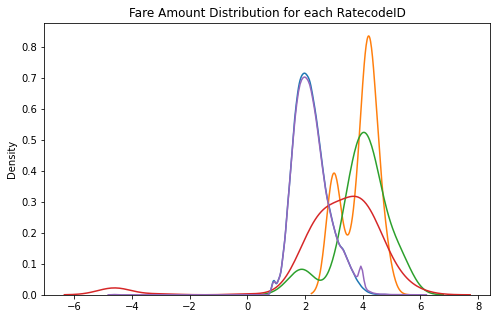

In [55]:
#Splitting train df based on the value of RatecodeID

train_standard = train[train["RatecodeID"]==1.0]
train_JFK = train[train["RatecodeID"]==2.0]
train_newark = train[train["RatecodeID"]==3.0]
train_Nassau = train[train["RatecodeID"]==4.0]
train_Negotiated = train[train["RatecodeID"]==5.0]
train_Group = train[train["RatecodeID"]==6.0]
train = train[train["RatecodeID"]!=99]

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train_standard['fare_amount'].values),label='train_standard')
#sns.kdeplot(np.log(train_JFK['fare_amount'].values),label='train_JFK') #JFK is always 52
sns.kdeplot(np.log(train_newark['fare_amount'].values),label='train_newark')
sns.kdeplot(np.log(train_Nassau['fare_amount'].values),label='train_Nassau')
sns.kdeplot(np.log(train_Negotiated['fare_amount'].values),label='train_Negotiated')
#sns.kdeplot(np.log(train_Group['fare_amount'].values),label='train_Group')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution for each RatecodeID")
plt.show()

Obervations : \
1.) JFK airport fare_amount is always standard at 52 \
2.) train_newark fare_amount is relatively higher than others \
3.) train_Nassau fare_amount is inbetween standard and train_newark \
4.) train_Negotiated fare_amount has a lower peak and is more flatter with fare_amount inbetween standard and train_newark \
5.) train_newark and train_Nassau has two peaks \
6.) train_Group is empty \

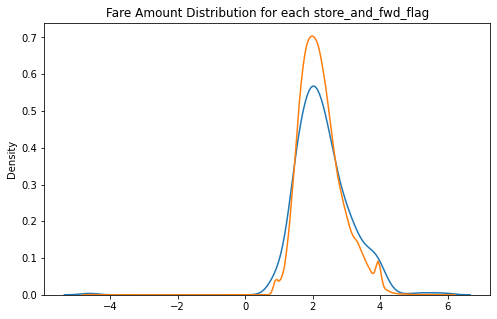

In [56]:
train_Storeandfwd_flag_Y  = train[train["store_and_fwd_flag"]=="Y"]
train_Storeandfwd_flag_N = train[train["store_and_fwd_flag"]=="N"]

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train_Storeandfwd_flag_Y['fare_amount'].values),label='Y')
sns.kdeplot(np.log(train_Storeandfwd_flag_N['fare_amount'].values),label='N')
#sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution for each store_and_fwd_flag")
plt.show()

Obervations : \
1.) store_and_fwd_flag for "N" fare_amount is more peaked than store_and_fwd_flag for "Y" \
2.) store_and_fwd_flag for "Y" fare_amount has fatter tails \
2.) store_and_fwd_flag for "N" and "Y" follow the same distribution

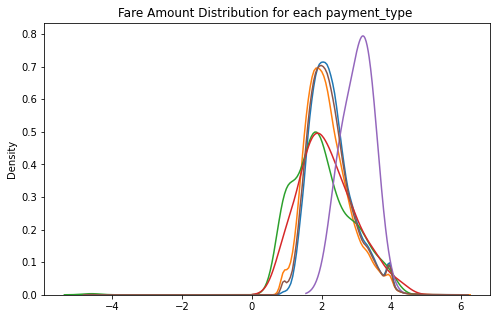

In [57]:
train_Credit_card = train[train["payment_type"]==1]
train_Cash = train[train["payment_type"]==2]
train_No_charge = train[train["payment_type"]==3]
train_Dispute = train[train["payment_type"]==4]
train_Unknown = train[train["payment_type"]==5]
train_Voided_trip = train[train["payment_type"]==6]

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train_Credit_card['fare_amount'].values),label='train_Credit_card')
sns.kdeplot(np.log(train_Cash['fare_amount'].values),label='train_Cash')
sns.kdeplot(np.log(train_No_charge['fare_amount'].values),label='train_No_charge')
sns.kdeplot(np.log(train_Dispute['fare_amount'].values),label='train_Dispute')
sns.kdeplot(np.log(train_Unknown['fare_amount'].values),label='train_Unknown') #unknown are charged more
sns.kdeplot(np.log(train_Voided_trip['fare_amount'].values),label='train_Voided_trip')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution for each payment_type ")
plt.show()

Obervations : \
1.) Unknown payment_type has relatively higher peak and mean than other payment_type \
2.) All payment_type except Unknown has similar distribution

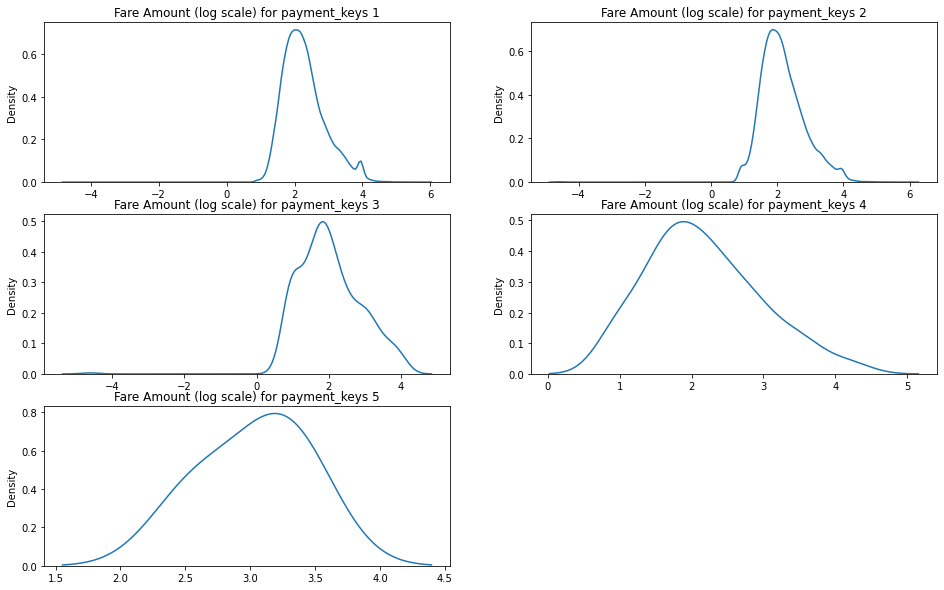

In [58]:
payment_keys = [1,2,3,4,5]

plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across payment_type")
i=1
for key in payment_keys:
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['payment_type']==key,'fare_amount'].values),label='Dropoff'+ str(key)).set_title("Fare Amount (log scale) for payment_keys "+ str(key))
    
    i=i+1
plt.show()

-----1 : Credit card \
---- 2 : Cash \
---- 3 : No charge \
---- 4 : Dispute \
---- 5 : Unknown \
---- 6 : Voided trip \
Obervations : \
1.) Credit card and Cash payment_type has similar fare_amount distribution \
2.) No charge payment_type fare_amount is relatively more spread out with lower peak \
3.) Dispute ahs a lower mean and peak overall, howerever it right skewed indicating few high fare_amount \
4.) tVoided trip payment_type has relatively higher mean

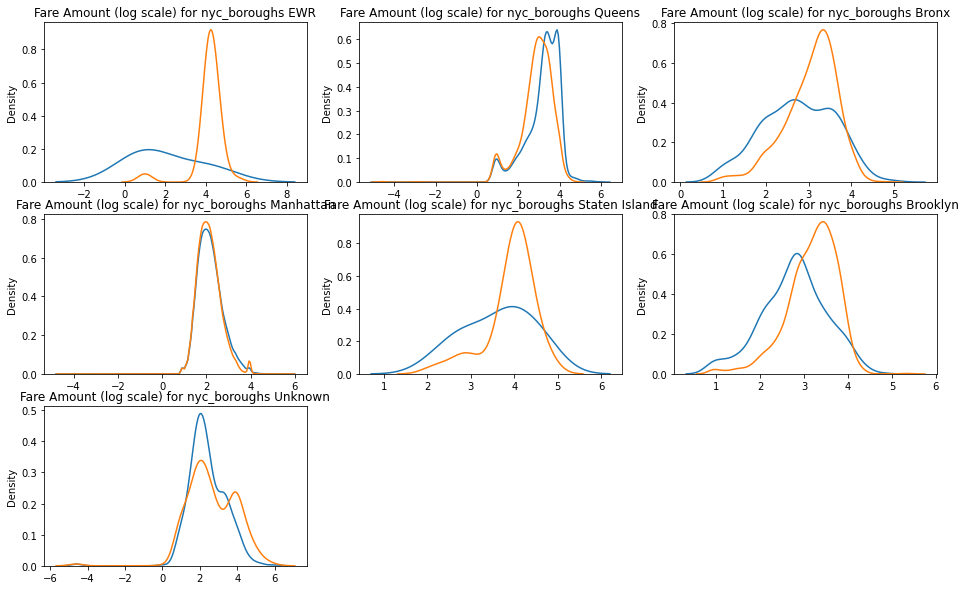

In [59]:
nyc_boroughs = ['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn','Unknown']

plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs:
    plt.subplot(3,3,i)
    sns.kdeplot(np.log(train.loc[train['PUBorough']==key,'fare_amount'].values),label='PUBorough '+ key)
    sns.kdeplot(np.log(train.loc[train['DOBorough']==key,'fare_amount'].values),label='DOBorough'+ key).set_title("Fare Amount (log scale) for nyc_boroughs "+key)
    
    i=i+1
plt.show()

Orange : DOBorough \
Blue : PUBorough \
Observations : \
1.) There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan \
2.) We can see pickups from Queens is expensive compared to pickups from other Buroughs \
3.) Very high difference in pickup and dropoff prices for Staten Island

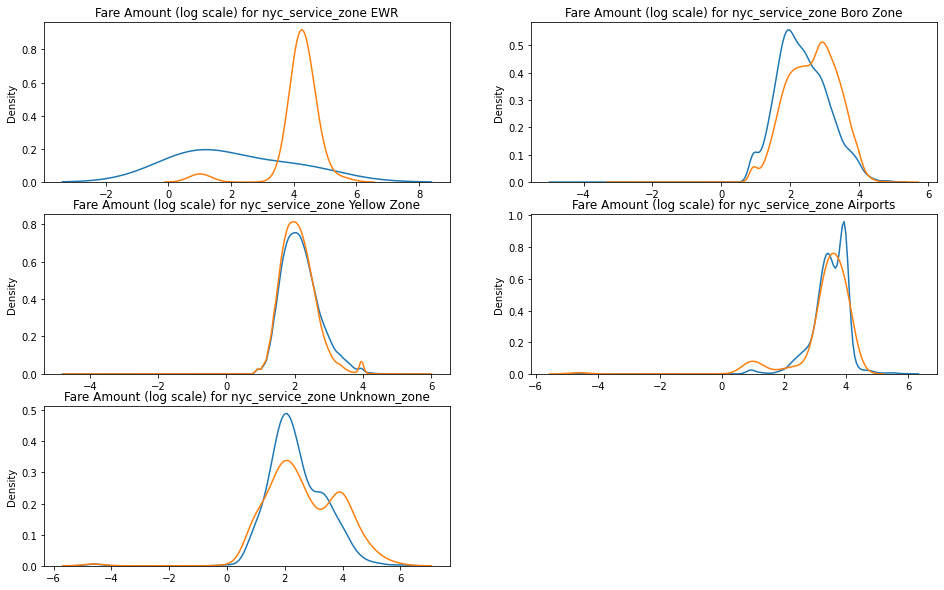

In [60]:
train["PUservice_zone"] = train["PUservice_zone"].fillna("Unknown_zone")
train["DOservice_zone"] = train["DOservice_zone"].fillna("Unknown_zone")

nyc_service_zone = ['EWR', 'Boro Zone', 'Yellow Zone', 'Airports', 'Unknown_zone']

plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_service_zone:
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['PUservice_zone']==key,'fare_amount'].values),label='PUservice_zone '+ key)
    sns.kdeplot(np.log(train.loc[train['DOservice_zone']==key,'fare_amount'].values),label='PUservice_zone'+ key).set_title("Fare Amount (log scale) for nyc_service_zone "+key)
    
    i=i+1
plt.show()

Orange : PUservice_zone \
Blue : DOservice_zone \
Observations : \
1.) There is a significant difference in pickups and dropoffs fare amount for each burough exceept Yellow Zone \
2.) We can see pickups from EWR and Unknown_zone is expensive compared to pickups from other service_zone \
3.) Very high difference in pickup and dropoff prices for EWR Island

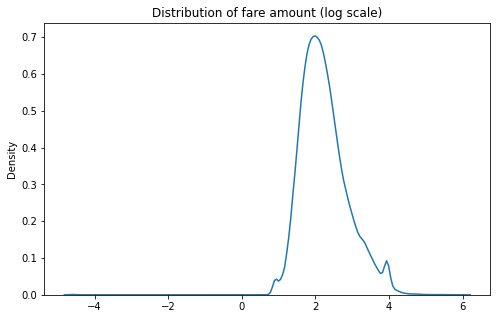

In [61]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")
plt.show()

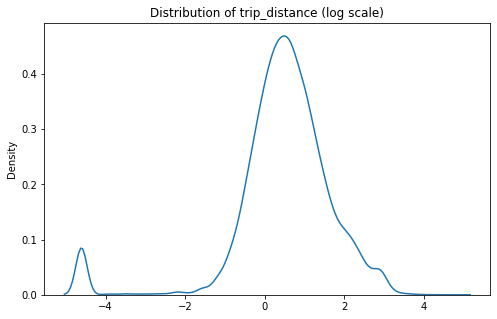

In [86]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Distribution of trip_distance (log scale)")
plt.show()

# Feature Engineering

In [63]:
def add_features(train):
    
    
    train["tpep_pickup_datetime"] = pd.to_datetime(train["tpep_pickup_datetime"])
    train["tpep_dropoff_datetime"] = pd.to_datetime(train["tpep_dropoff_datetime"])
    train['hour'] = train['tpep_pickup_datetime'].dt.hour
    train['day'] = train['tpep_pickup_datetime'].dt.day
    train['month'] = train['tpep_pickup_datetime'].dt.month
    train['year'] = train['tpep_pickup_datetime'].dt.year
    train['weekday'] = train['tpep_pickup_datetime'].dt.weekday
    train['quarter_of_year'] = train['tpep_pickup_datetime'].dt.quarter
    train["date_diff"] = train["tpep_dropoff_datetime"]-train["tpep_pickup_datetime"]
    
    train["date_diff"] = train["date_diff"].astype(str)

    train["trip_time_minutes"] = train["date_diff"].str.slice(10,12,1)
    train["trip_time_seconds"] = train["date_diff"].str.slice(13,15,1)

    train["trip_time_minutes"] = train["trip_time_minutes"].astype(int)
    train["trip_time_seconds"] = train["trip_time_seconds"].astype(int)

    train["time_trip"] = (60*train["trip_time_minutes"]+train["trip_time_seconds"])/60

    train.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime", "date_diff", "trip_time_minutes", "trip_time_seconds"], inplace=True)
    
        
    train_mapping_1 = train_mapping.copy()
    train_mapping_2 = train_mapping.copy()
    
    train_mapping_PU = train_mapping_1
    train_mapping_PU = train_mapping_PU.drop(columns="Zone")
    train_mapping_PU["PULocationID"] = train_mapping_PU["LocationID"]
    train_mapping_PU["PUBorough"] = train_mapping_PU["Borough"]
    train_mapping_PU["PUservice_zone"] = train_mapping_PU["service_zone"]
    train_mapping_PU = train_mapping_PU.drop(columns="Borough")
    train_mapping_PU = train_mapping_PU.drop(columns="service_zone")
    train_mapping_PU = train_mapping_PU.drop(columns="LocationID")

    train_mapping_DO = train_mapping_1
    train_mapping_DO = train_mapping_DO.drop(columns="Zone")
    train_mapping_DO["DOLocationID"] = train_mapping_DO["LocationID"]
    train_mapping_DO["DOBorough"] = train_mapping_DO["Borough"]
    train_mapping_DO["DOservice_zone"] = train_mapping_DO["service_zone"]
    train_mapping_DO = train_mapping_DO.drop(columns="Borough")
    train_mapping_DO = train_mapping_DO.drop(columns="service_zone")
    train_mapping_DO = train_mapping_DO.drop(columns="LocationID")

    train = pd.merge(train, train_mapping_PU, on='PULocationID')
    train = pd.merge(train, train_mapping_DO, on='DOLocationID')
    
    
    store_and_fwd_flag_mean_map = {"Y":15.00, "N":11.95}
    store_and_fwd_flag_medain_map = {"Y":9.0, "N":8.5}

    train["store_and_fwd_flag_mean"] = train["store_and_fwd_flag"].apply(lambda x:store_and_fwd_flag_mean_map[x])
    train["store_and_fwd_flag_medain"] = train["store_and_fwd_flag"].apply(lambda x:store_and_fwd_flag_medain_map[x])


    payment_type_mean_map = {1:12.37, 2:11.22, 3:11.17, 4:12.32, 5:21.83, 6:12.37}
    payment_type_medain_map = {1:9.0, 2:8.0, 3:7.0, 4:8.0, 5:23.0, 6:9.0}
    train["payment_type_mean"] = train["payment_type"].apply(lambda x:payment_type_mean_map[x])
    train["payment_type_median"] = train["payment_type"].apply(lambda x:payment_type_medain_map[x])


    RatecodeID_mean_map = {1:11.24, 2:52.0, 3:57.67, 4:72.38, 5:45.50, 6:45.50, 99:1}
    RatecodeID_medain_map = {1:8.5, 2:52.0, 3:64.0, 4:57.0, 5:29.0, 6:29.0, 99:8.5}

    train["RatecodeID_mean"] = train["RatecodeID"].apply(lambda x:RatecodeID_mean_map[x])
    train["RatecodeID_medain"] = train["RatecodeID"].apply(lambda x:RatecodeID_medain_map[x])


    PUBorough_mean_map = {'EWR':21.83, 'Queens':31.66, 'Bronx':21.77, 'Manhattan':10.55, 'Staten Island':48.96, 'Brooklyn':20.62,'Unknown':18.08}
    PUBorough_median_map = {'EWR':3.0, 'Queens':29.0, 'Bronx':15.5, 'Manhattan':8.5, 'Staten Island':40.25, 'Brooklyn':17.0,'Unknown':9.5}

    train["PUBorough_mean"] = train["PUBorough"].apply(lambda x:PUBorough_mean_map[x])
    train["PUBorough_medain"] = train["PUBorough"].apply(lambda x:PUBorough_median_map[x])
    

    DOBorough_mean_map = {'EWR':74.87, 'Queens':22.89, 'Bronx':24.94, 'Manhattan':9.91, 'Staten Island':57.03, 'Brooklyn':27.77,'Unknown':29.94}
    DOBorough_median_map = {'EWR':68.5, 'Queens':20.0, 'Bronx':24.0, 'Manhattan':8.0, 'Staten Island':58.0, 'Brooklyn':26.2,'Unknown':11.8}

    train["DOBorough_mean"] = train["DOBorough"].apply(lambda x:DOBorough_mean_map[x])
    train["DOBorough_medain"] = train["DOBorough"].apply(lambda x:DOBorough_median_map[x])
    
    
    train["PUservice_zone"] = train["PUservice_zone"].fillna("Unknown_zone")

    PUservice_zone_mean_map = {'Yellow Zone':10.49, 'Boro Zone':13.92, 'Airports':37.60, 'Unknown_zone':18.08, 'EWR':21.83}
    PUservice_zone_medain_map = {'Yellow Zone':8.5, 'Boro Zone':10.0, 'Airports':34.5, 'Unknown_zone':9.5, 'EWR':3.0}

    train["PUservice_zone_mean"] = train["PUservice_zone"].apply(lambda x:PUservice_zone_mean_map[x])
    train["PUservice_zone_medain"] = train["PUservice_zone"].apply(lambda x:PUservice_zone_medain_map[x])
    
    
    train["DOservice_zone"] = train["DOservice_zone"].fillna("Unknown_zone")

    DOservice_zone_mean_map = {'Yellow Zone':9.51, 'Boro Zone':18.04, 'Airports':34.77, 'Unknown_zone':29.94, 'EWR':74.87}
    DOservice_zone_medain_map = {'Yellow Zone':8.0, 'Boro Zone':14.5, 'Airports':32.5, 'Unknown_zone':11.8, 'EWR':68.5}

    train["DOservice_zone_mean"] = train["DOservice_zone"].apply(lambda x:DOservice_zone_mean_map[x])
    train["DOservice_zone_medain"] = train["DOservice_zone"].apply(lambda x:DOservice_zone_medain_map[x])
    
    train["speed"] = 60*(train["trip_distance"]+0.01)/(train["time_trip"]+0.01)
    train["dist_times_time"] = ((train["trip_distance"]+0.01)*(train["time_trip"]+0.01))
    train["dist_am_time"] = (train["trip_distance"]+train["time_trip"]+0.02)/2
    train["dist_hm_time"] = train["trip_distance"]*train["time_trip"]/(train["trip_distance"]+train["time_trip"]+0.02)
    train["time_mean"] = np.mean(train["dist_times_time"])/(train["trip_distance"]+0.01)
    train["dist_mean"] = np.mean(train["dist_times_time"])/(train["time_trip"]+0.01)
    train["inverse_speed"] = 1/(train["speed"]+0.01)
    
    train = train.drop(columns=["store_and_fwd_flag","PUBorough","DOBorough","PUservice_zone","DOservice_zone"])

    return train

In [64]:
train = pd.read_csv("train_data_iitm.csv")
train = train.dropna()
train = train[train["fare_amount"]>0]

test = pd.read_csv("test_data_iitm.csv")
test["VendorID"] = test["VendorID"].replace([np.nan],1)
test["RatecodeID"] = test["RatecodeID"].replace([99,np.nan],1)
test["passenger_count"] = test["passenger_count"].replace([0,np.nan],1)
test["store_and_fwd_flag"] = test["store_and_fwd_flag"].replace([np.nan],"Y")
test["payment_type"] = test["payment_type"].replace([np.nan],1)

In [65]:
train_merge_3 = add_features(train)
test_merge_3 = add_features(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Distribution of time_trip (log scale)')

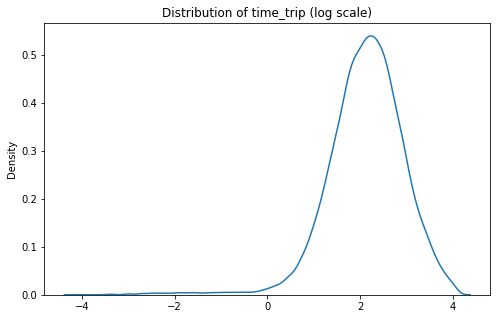

In [87]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['time_trip'].values)).set_title("Distribution of time_trip (log scale)")

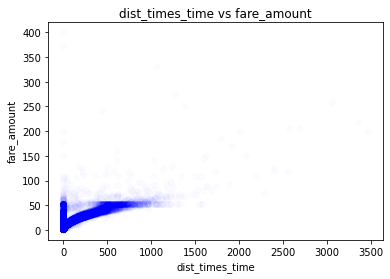

In [67]:
plt.scatter(x=train_merge_3["dist_times_time"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("dist_times_time")
plt.ylabel("fare_amount")
plt.title("dist_times_time vs fare_amount")
plt.show()

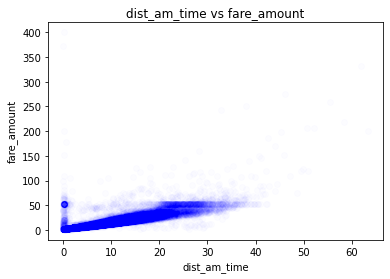

In [68]:
plt.scatter(x=train_merge_3["dist_am_time"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("dist_am_time")
plt.ylabel("fare_amount")
plt.title("dist_am_time vs fare_amount")
plt.show()

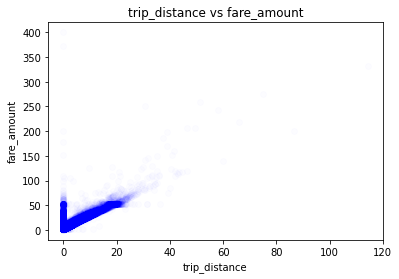

In [69]:
plt.scatter(x=train_merge_3["trip_distance"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("trip_distance")
plt.ylabel("fare_amount")
plt.title("trip_distance vs fare_amount")
plt.show()

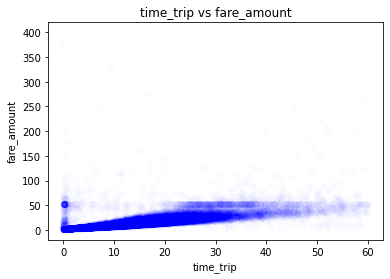

In [70]:
plt.scatter(x=train_merge_3["time_trip"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("time_trip")
plt.ylabel("fare_amount")
plt.title("time_trip vs fare_amount")
plt.show()

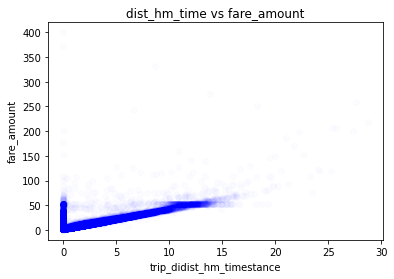

In [71]:
plt.scatter(x=train_merge_3["dist_hm_time"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("trip_didist_hm_timestance")
plt.ylabel("fare_amount")
plt.title("dist_hm_time vs fare_amount")
plt.show()

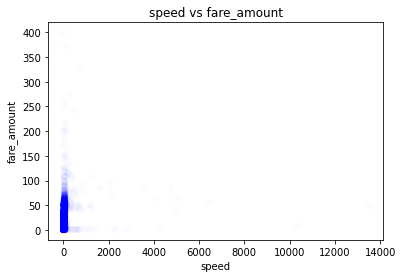

In [72]:
plt.scatter(x=train_merge_3["speed"],y=train_merge_3["fare_amount"], color="b", alpha=0.01)
plt.xlabel("speed")
plt.ylabel("fare_amount")
plt.title("speed vs fare_amount")
plt.show()

# Data Cleaning

In [73]:
def remove_outliers(train_merge_2):
    train_merge_2 = train_merge_2[train_merge_2["speed"]<25]
    train_merge_2 = train_merge_2[train_merge_2["trip_distance"]<20]
    train_merge_2 = train_merge_2[train_merge_2["fare_amount"]<100]
    # train_merge_2 = train_merge_2[train_merge_2["trip_distance"]>0]
    # train_merge_2 = train_merge_2[train_merge_2["time_trip"]>0]
    train_merge_2["fare_per_dist"] = train_merge_2["fare_amount"]/(train_merge_2["trip_distance"]+0.01)
    train_merge_2["fare_per_time"] = train_merge_2["fare_amount"]/(train_merge_2["time_trip"]+0.01)
    train_merge_2 = train_merge_2[train_merge_2["fare_per_dist"]<50]
    train_merge_2 = train_merge_2[train_merge_2["fare_per_time"]<100]

    train_merge_2 = train_merge_2.drop(columns=["fare_per_dist", "fare_per_time"])
    
    return train_merge_2

In [74]:
train_merge_3 = remove_outliers(train_merge_3)

# Data Modelling

In [75]:
y = train_merge_3["fare_amount"]
X = train_merge_3.drop(columns="fare_amount")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
trainshape = X_train.shape
testshape = test_merge_3.shape
dtrain = lgb.Dataset(X_train, label = y_train, free_raw_data = False)

In [77]:
# print("Light Gradient Boosting Regressor: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate' :'0.03',
    'num_leaves':'31',
    'max_depth' : '-1',
    'subsample' :'.8',
     'colsample_bytree' : '0.6',
        'min_split_gain' : '0.5',
        'min_child_weight' : '1',
        'min_child_samples' :'10',
        'scale_pos_weight' : '1',
        'num_threads' : '4',
        'seed' : '0',
        'eval_freq' : '50'
                }

folds = KFold(n_splits=5, shuffle=True, random_state=1)
fold_preds = np.zeros(testshape[0])
oof_preds = np.zeros(trainshape[0])
dtrain.construct()

# Fit 5 Folds
modelstart = time.time()
for trn_idx, val_idx in folds.split(X_train):
    clf = lgb.train(
        params=lgbm_params,
        train_set=dtrain.subset(trn_idx),
        valid_sets=dtrain.subset(val_idx),
        num_boost_round=10000, 
        early_stopping_rounds=125,
        verbose_eval=500     
    )
    oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
    fold_preds += clf.predict(test_merge_3) / folds.n_splits
    print(mean_squared_error(y_train.iloc[val_idx], oof_preds[val_idx]))
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
# model = lgb.LGBMRegressor(**lgbm_params)

Training until validation scores don't improve for 125 rounds.
[500]	valid_0's rmse: 1.07205
Early stopping, best iteration is:
[407]	valid_0's rmse: 1.07201
1.1492066153228804
Training until validation scores don't improve for 125 rounds.
Early stopping, best iteration is:
[342]	valid_0's rmse: 0.729717
0.5324863620068641
Training until validation scores don't improve for 125 rounds.
Early stopping, best iteration is:
[155]	valid_0's rmse: 0.779236
0.607209397341849
Training until validation scores don't improve for 125 rounds.
[500]	valid_0's rmse: 0.748763
Early stopping, best iteration is:
[399]	valid_0's rmse: 0.748363
0.5600472341625191
Training until validation scores don't improve for 125 rounds.
Early stopping, best iteration is:
[227]	valid_0's rmse: 0.971358
0.9435362848037933
Model Runtime: 0.23 Minutes


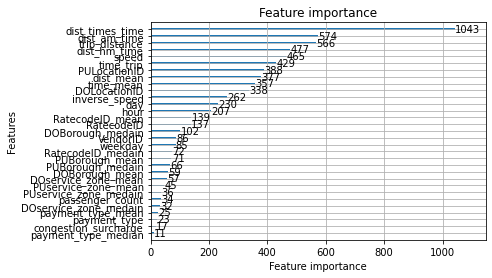

In [78]:
lgb.plot_importance(clf)

# Prediction

In [79]:
train_pred = clf.predict(X)
mean_squared_error(train_pred,y)

0.4937522100729392

In [80]:
train_pred = clf.predict(X_train)
mean_squared_error(train_pred,y_train)

0.42338577830415874

In [81]:
train_pred = clf.predict(X_test)
mean_squared_error(train_pred,y_test)

0.6366149893688545

Training error : 0.407 \
Validation error : 0.630

# Final Submission

In [95]:
#final_submission
final_submission = pd.read_csv("test_data_iitm.csv")
final_submission["fare_amount"] = fold_preds

In [98]:
final_submission.to_csv("NA18B030_Ramakrishnan_predictions.csv", index=False)

In [99]:
final_submission

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,congestion_surcharge,fare_amount
0,2.0,2020-06-30 18:39:30,2020-06-30 18:45:11,1.0,1.66,1.0,N,48,90,1.0,2.5,6.877551
1,2.0,2020-06-27 23:16:17,2020-06-27 23:23:17,3.0,1.50,1.0,N,48,246,2.0,2.5,7.721475
2,1.0,2020-06-09 12:54:15,2020-06-09 13:01:25,1.0,1.90,1.0,N,237,234,1.0,2.5,8.003721
3,2.0,2020-06-20 09:42:39,2020-06-20 09:45:12,1.0,0.27,1.0,N,170,170,2.0,2.5,8.581349
4,2.0,2020-06-23 18:31:46,2020-06-23 18:48:34,2.0,4.06,1.0,N,186,238,2.0,2.5,10.869591
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,2020-06-09 23:25:53,2020-06-09 23:26:01,1.0,0.00,1.0,N,74,74,3.0,0.0,10.394016
9996,2.0,2020-06-03 13:07:44,2020-06-03 13:11:27,1.0,0.54,1.0,N,141,237,1.0,2.5,3.505270
9997,2.0,2020-06-07 18:40:08,2020-06-07 18:46:23,1.0,1.14,1.0,N,41,74,1.0,0.0,8.689619
9998,2.0,2020-06-12 15:27:56,2020-06-12 15:42:42,1.0,2.92,1.0,N,88,65,1.0,2.5,46.224712
